In [1]:
import torch
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import perturbed_organics.utils as utils
import math


# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cmap = 'plasma_r'

In [26]:
input_type = 'delocalized'
mu = "0.0"
mu_val = float(mu)

# folder_loc = f'/scratch/sr6364/perturbed_organics/data/adaptive_phase_diagram_100/{input_type}'
# folder_name = f'{input_type}_goe_symmetric_N_100_s_100_mu_{mu}_num_delta_200_num_input_200_num_trials_100_b0_1.0_b1_1.0_phase_diagram_linear'
# folder_name = f'{input_type}_goe_symmetric_N_100_s_100_mu_{mu}_num_delta_200_num_input_200_num_trials_100_b0_1.0_b1_1.0_phase_diagram_log-scale'


folder_loc = f'/scratch/sr6364/perturbed_organics/data/adaptive_phase_diagram_rectified/{input_type}'
folder_name = f'{input_type}_goe_symmetric_N_100_s_100_mu_{mu}_num_delta_50_num_input_50_num_trials_100_b0_1.0_b1_1.0_phase_diagram_linear'

path = os.path.join(folder_loc, folder_name)

In [27]:
# Load parameters from the JSON file
param_file_path = os.path.join(path, 'parameters.json')
with open(param_file_path, 'r') as f:
    params = json.load(f)

# Extract parameters
N = params['N']
num_tasks = params['num_tasks']
num_delta = params['num_delta']
num_input = params['num_input']
num_trials = params['num_trials']
delta_scale = params['delta_scale']
delta_range = np.array(params['delta_range'])
input_range = np.array(params['input_range'])

In [28]:
condition = torch.load(os.path.join(path, f'condition.pt'))
norm_fixed_point_y = torch.load(os.path.join(path, f'norm_fixed_point_y.pt'))
actual_fixed_point_y = torch.load(os.path.join(path, f'actual_fixed_point_y.pt'))
first_order_perturb_y = torch.load(os.path.join(path, f'first_order_perturb_y.pt'))

In [29]:
bool_stable = torch.where(condition == 2, True, False)
# bool_limit_cycle = torch.where((condition == 0) | (condition == 3), True, False)
bool_limit_cycle = torch.where(condition == 3, True, False)
bool_not_converged = torch.where(condition == 0, True, False)
bool_unstable = torch.where(condition == 1, True, False)

In [30]:
# Proceed with plotting or further analysis
percent_stable = bool_stable.float().mean(dim=2) * 100
percent_notstable = 100 - percent_stable

percent_limit_cycle = bool_limit_cycle.float().mean(dim=2) * 100

percent_unstable = bool_unstable.float().mean(dim=2) * 100
percent_not_converged = bool_not_converged.float().mean(dim=2) * 100

In [31]:
# analytical prediction from perturbation theory
num_points_to_exclude = 3
idx = 0
norm_sol_idx = []
for input_norm in input_range:
    z = utils.make_input_drive(N=N, input_type=params['model_name'], input_norm=input_norm)
    norm_eqn = torch.sqrt(z ** 2 / (params['sigma']**2 + torch.norm(z) ** 2))
    norm_sol_idx.append(norm_eqn[idx].item())
norm_sol_idx = np.array(norm_sol_idx)

# analytical solution for the mean of the fixed point
G = (1 - np.sqrt(params['sigma'] ** 2 + input_range ** 2)) / (params['sigma'] ** 2 + input_range ** 2)
analytical_mean = norm_sol_idx + mu_val * input_range * G * (1 - input_range ** 2 / (params['sigma'] ** 2 + input_range ** 2)) / np.sqrt(N)


delta_c =  math.sqrt(2 * N) * analytical_mean / (G * input_range)
delta_c = delta_c[:-num_points_to_exclude]
new_input_norm = input_range[:-num_points_to_exclude]

In [32]:
folder_loc = f'../figures/mu_{mu}/fig4'
os.makedirs(folder_loc, exist_ok=True)

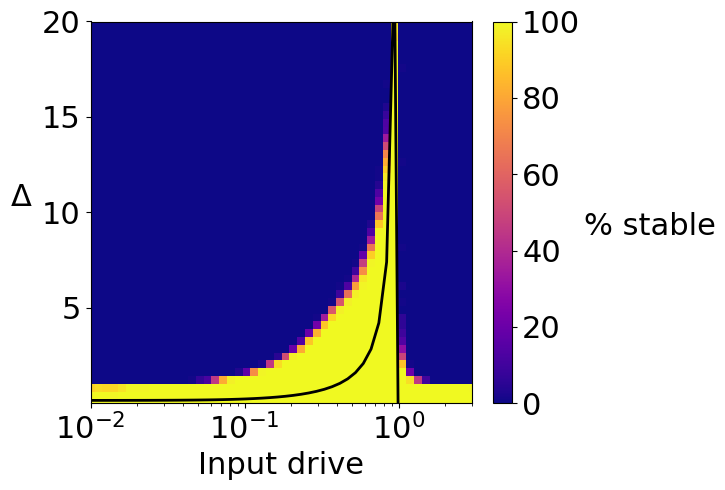

In [33]:
plt.figure(figsize=(7.5, 5))
norm = mcolors.Normalize(vmin=0, vmax=100, clip=False)
mesh = plt.pcolormesh(input_range, delta_range, percent_stable, cmap='plasma', norm=norm)
plt.plot(new_input_norm, delta_c, color='k', linewidth=2.0, label=r'$\Delta_c$')

colorbar = plt.colorbar(mesh, fraction=0.046, pad=0.04)
colorbar.ax.tick_params(labelsize=22)
colorbar.ax.set_ylabel(r"% stable", fontsize=22, rotation=0, labelpad=50)
plt.xlabel('Input drive', fontsize=22)
plt.ylabel(r'$\Delta$', fontsize=22, rotation=0, labelpad=15)
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(4))
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

ax = plt.gca()
if delta_scale == 'log-scale':
    plt.yscale('log')  # Ensure the axis is in log scale
    y_span = np.log10(delta_range[-1]) - np.log10(delta_range[0])
else:  
    y_span = delta_range[-1] - delta_range[0]

plt.xscale('log')
x_span = np.log10(input_range[-1]) - np.log10(input_range[0])
ax.set_aspect(x_span / y_span, adjustable='box')

plt.xlim([input_range[0], input_range[-1]])
plt.ylim([delta_range[0], delta_range[-1]])

file_name = f'percent_stable_{input_type}'
file_save_path = os.path.join(folder_loc, file_name)

plt.tight_layout()
plt.savefig(f'{file_save_path}.png', bbox_inches='tight')
plt.savefig(f'{file_save_path}.svg', format='svg', bbox_inches='tight', dpi=300)
plt.savefig(f'{file_save_path}.eps', format='eps', bbox_inches='tight', dpi=300)
plt.show()

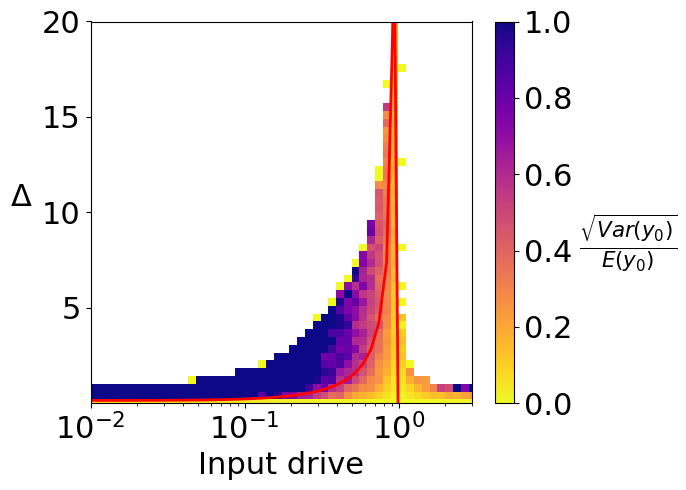

In [34]:
plt.figure(figsize=(7.5, 5))

idx = 0

norm = mcolors.Normalize(vmin=0, vmax=1, clip=True)

# calculate the avg ratio of deviation from norm fixed point for y
# y1_squared_norm = torch.norm(norm_fixed_point_y - actual_fixed_point_y, dim=3) ** 2 # deviation from the fixed point
# y0_squared_norm = torch.norm(norm_fixed_point_y, dim=3) ** 2
# y_ratio = y1_squared_norm / y0_squared_norm
# y_ratio_mean = torch.sqrt(torch.mean(y_ratio, dim=2))
# y_ratio_mean = torch.sqrt(torch.nanmean(y_ratio, dim=2))

# code for the standard deviation over mean criterion
y_val = actual_fixed_point_y[:, :, :, idx]
y_val_std = utils.nanstd(y_val, dim=2)
# y_val_std = np.nanstd(y_val, axis=2)
y_val_mean = torch.nanmean(y_val, dim=2)
y_ratio_mean = torch.abs(y_val_std / y_val_mean)

mesh = plt.pcolormesh(input_range, delta_range, y_ratio_mean, cmap=cmap, norm=norm)
plt.plot(new_input_norm, delta_c, color='red', linewidth=2.0, label=r'$\Delta_c$')

colorbar = plt.colorbar(mesh, fraction=0.046, pad=0.04)
colorbar.ax.tick_params(labelsize=22)
# colorbar.ax.set_ylabel(r"$\frac{||\mathbf{y}-\mathbf{y}_0||}{||\mathbf{y}_0||}$", fontsize=22, rotation=0, labelpad=40)
colorbar.ax.set_ylabel(r"$\frac{\sqrt{Var(y_0)}}{E(y_0)}$", fontsize=22, rotation=0, labelpad=40)
plt.xlabel('Input drive', fontsize=22)
plt.ylabel(r'$\Delta$', fontsize=22, rotation=0, labelpad=15)
# plt.title("Actual Mean Ratio of Norm Difference for y", fontsize=22)
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(4))
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

ax = plt.gca()
if delta_scale == 'log-scale':
    plt.yscale('log')  # Ensure the axis is in log scale
    y_span = np.log10(delta_range[-1]) - np.log10(delta_range[0])
else:  
    y_span = delta_range[-1] - delta_range[0]

plt.xscale('log')
x_span = np.log10(input_range[-1]) - np.log10(input_range[0])
ax.set_aspect(x_span / y_span, adjustable='box')

plt.xlim([input_range[0], input_range[-1]])
plt.ylim([delta_range[0], delta_range[-1]])

file_name = f'norm_ratio_{input_type}'
file_save_path = os.path.join(folder_loc, file_name)

plt.tight_layout()
plt.savefig(f'{file_save_path}.png', bbox_inches='tight')
plt.savefig(f'{file_save_path}.svg', format='svg', bbox_inches='tight', dpi=300)
plt.savefig(f'{file_save_path}.eps', format='eps', bbox_inches='tight', dpi=300)
plt.show()

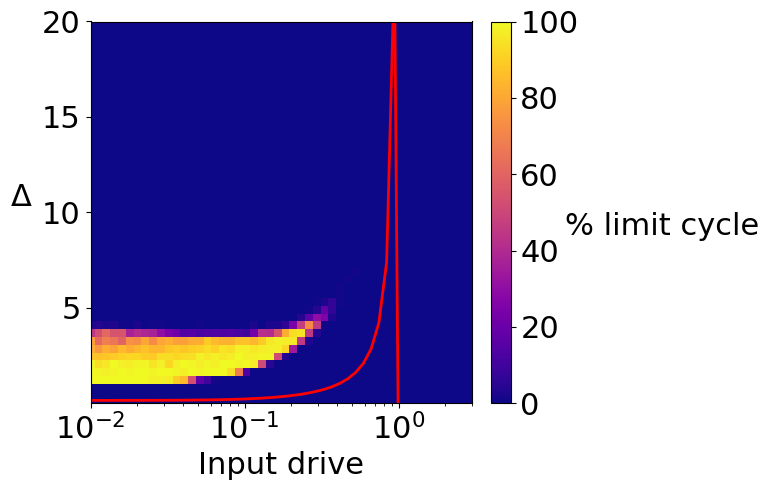

In [35]:
# We plot the percent of limit cycles detected

plt.figure(figsize=(7.5, 5))
norm = mcolors.Normalize(vmin=0, vmax=100, clip=False)
mesh = plt.pcolormesh(input_range, delta_range, percent_limit_cycle, cmap='plasma', norm=norm)
plt.plot(new_input_norm, delta_c, color='r', linewidth=2.0, label=r'$\Delta_c$')

colorbar = plt.colorbar(mesh, fraction=0.046, pad=0.04)
colorbar.ax.tick_params(labelsize=22)
colorbar.ax.set_ylabel(r"% limit cycle", fontsize=22, rotation=0, labelpad=60)
plt.xlabel('Input drive', fontsize=22)
plt.ylabel(r'$\Delta$', fontsize=22, rotation=0, labelpad=15)
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(4))
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)


ax = plt.gca()
if delta_scale == 'log-scale':
    plt.yscale('log')  # Ensure the axis is in log scale
    y_span = np.log10(delta_range[-1]) - np.log10(delta_range[0])
else:  
    y_span = delta_range[-1] - delta_range[0]

plt.xscale('log')
x_span = np.log10(input_range[-1]) - np.log10(input_range[0])
ax.set_aspect(x_span / y_span, adjustable='box')

plt.xlim([input_range[0], input_range[-1]])
plt.ylim([delta_range[0], delta_range[-1]])

file_name = f'percent_limit_cycle_{input_type}'
file_save_path = os.path.join(folder_loc, file_name)

plt.tight_layout()
plt.savefig(f'{file_save_path}.png', bbox_inches='tight')
plt.savefig(f'{file_save_path}.svg', format='svg', bbox_inches='tight', dpi=300)
plt.savefig(f'{file_save_path}.eps', format='eps', bbox_inches='tight', dpi=300)
plt.show()


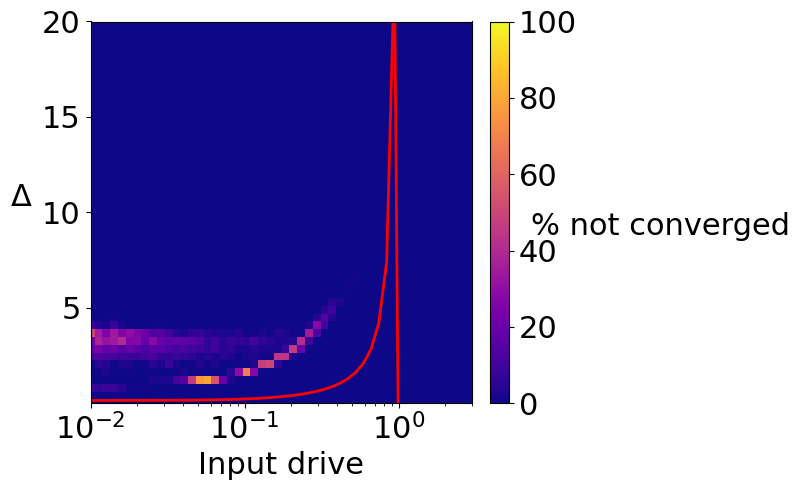

In [36]:
# We plot the percent of simulations not converged

plt.figure(figsize=(7.5, 5))
norm = mcolors.Normalize(vmin=0, vmax=100, clip=False)
mesh = plt.pcolormesh(input_range, delta_range, percent_not_converged, cmap='plasma', norm=norm)
plt.plot(new_input_norm, delta_c, color='r', linewidth=2.0, label=r'$\Delta_c$')

colorbar = plt.colorbar(mesh, fraction=0.046, pad=0.04)
colorbar.ax.tick_params(labelsize=22)
colorbar.ax.set_ylabel(r"% not converged", fontsize=22, rotation=0, labelpad=60)
plt.xlabel('Input drive', fontsize=22)
plt.ylabel(r'$\Delta$', fontsize=22, rotation=0, labelpad=15)
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(4))
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)


ax = plt.gca()
if delta_scale == 'log-scale':
    plt.yscale('log')  # Ensure the axis is in log scale
    y_span = np.log10(delta_range[-1]) - np.log10(delta_range[0])
else:  
    y_span = delta_range[-1] - delta_range[0]

plt.xscale('log')
x_span = np.log10(input_range[-1]) - np.log10(input_range[0])
ax.set_aspect(x_span / y_span, adjustable='box')

plt.xlim([input_range[0], input_range[-1]])
plt.ylim([delta_range[0], delta_range[-1]])

file_name = f'percent_not_converged_{input_type}'
file_save_path = os.path.join(folder_loc, file_name)

plt.tight_layout()
plt.savefig(f'{file_save_path}.png', bbox_inches='tight')
plt.savefig(f'{file_save_path}.svg', format='svg', bbox_inches='tight', dpi=300)
plt.savefig(f'{file_save_path}.eps', format='eps', bbox_inches='tight', dpi=300)

plt.show()


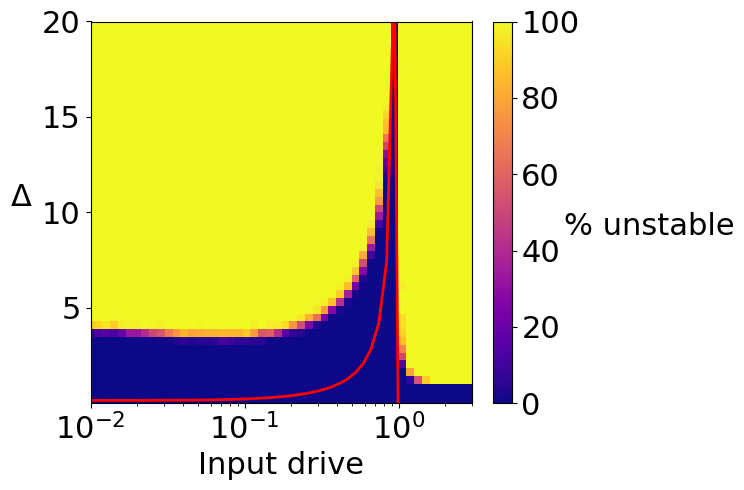

In [37]:
# We plot the percent of unstable detected

plt.figure(figsize=(7.5, 5))
norm = mcolors.Normalize(vmin=0, vmax=100, clip=False)
mesh = plt.pcolormesh(input_range, delta_range, percent_unstable, cmap='plasma', norm=norm)
plt.plot(new_input_norm, delta_c, color='r', linewidth=2.0, label=r'$\Delta_c$')


colorbar = plt.colorbar(mesh, fraction=0.046, pad=0.04)
colorbar.ax.tick_params(labelsize=22)
colorbar.ax.set_ylabel(r"% unstable", fontsize=22, rotation=0, labelpad=50)
plt.xlabel('Input drive', fontsize=22)
plt.ylabel(r'$\Delta$', fontsize=22, rotation=0, labelpad=15)
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(4))
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)


ax = plt.gca()
if delta_scale == 'log-scale':
    plt.yscale('log')  # Ensure the axis is in log scale
    y_span = np.log10(delta_range[-1]) - np.log10(delta_range[0])
else:  
    y_span = delta_range[-1] - delta_range[0]

plt.xscale('log')
x_span = np.log10(input_range[-1]) - np.log10(input_range[0])
ax.set_aspect(x_span / y_span, adjustable='box')

plt.xlim([input_range[0], input_range[-1]])
plt.ylim([delta_range[0], delta_range[-1]])

file_name = f'percent_unstable_{input_type}'
file_save_path = os.path.join(folder_loc, file_name)

plt.tight_layout()
plt.savefig(f'{file_save_path}.png', bbox_inches='tight')
plt.savefig(f'{file_save_path}.svg', format='svg', bbox_inches='tight', dpi=300)
plt.savefig(f'{file_save_path}.eps', format='eps', bbox_inches='tight', dpi=300)

plt.show()


### Dicover the pattern the about center manifold using the eigenvalues of the jacobian matrix

In [38]:
eigvals = torch.load(os.path.join(path, f'eigvals_J.pt'))
print(eigvals.shape) # num_delta, num_input, num_trials, 2*N)

torch.Size([50, 50, 100, 200])


In [39]:
# fit and find the intersection of mean and variance
stability_criterion_percent = 0.99
fitted_intersection = np.zeros((len(delta_range)))
idx = 0

for i, delta_val in enumerate(delta_range):
    actual_fp_y = actual_fixed_point_y[i, :, :, :]
    y_val = actual_fp_y[:, :, idx]

    y_val_mean = torch.nanmean(y_val, dim=1)
    y_val_std = utils.nanstd(y_val, dim=1)

    # check if unstable
    ratio_stable = torch.sum(~torch.isnan(y_val), dim=1) / num_trials
    mask = (ratio_stable > stability_criterion_percent).cpu().numpy()

    # fit the mean
    x_vals = np.array(input_range)[mask].astype(np.float64)
    y_vals = np.array(y_val_mean[mask]).astype(np.float64)
    coeffs = np.polyfit(np.log10(x_vals), y_vals, deg=5)
    poly_func = np.poly1d(coeffs)
    x_fit_mean = np.logspace(np.log10(x_vals.min()), np.log10(x_vals.max()), 200)
    y_fit_mean = poly_func(np.log10(x_fit_mean))

    # fit the std
    x_vals = np.array(input_range)[mask].astype(np.float64)
    y_vals = np.array(y_val_std[mask]).astype(np.float64)
    coeffs = np.polyfit(np.log10(x_vals), y_vals, deg=5)
    poly_func = np.poly1d(coeffs)
    x_fit_std = np.logspace(np.log10(x_vals.min()), np.log10(x_vals.max()), 200)
    y_fit_std = poly_func(np.log10(x_fit_std))

    # find the intersection
    diff = y_fit_mean - y_fit_std

    # Find indices where the difference changes sign.
    sign_change_idxs = np.where(np.diff(np.sign(diff)))[0]

    if sign_change_idxs.size > 0:
        # Take the first crossing.
        idx1 = sign_change_idxs[0]
        # Define the two x values and the corresponding differences.
        x0, x1 = x_fit_mean[idx1], x_fit_mean[idx1 + 1]
        d0, d1 = diff[idx1], diff[idx1 + 1]
        
        # Linear interpolation to estimate the intersection.
        t = -d0 / (d1 - d0)
        x_intersect = x0 + t * (x1 - x0)
        
        fitted_intersection[i] = x_intersect
    else:
        fitted_intersection[i] = np.nan

/tmp/ipykernel_1617626/2126215066.py:20: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(np.log10(x_vals), y_vals, deg=5)
/tmp/ipykernel_1617626/2126215066.py:28: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(np.log10(x_vals), y_vals, deg=5)
/tmp/ipykernel_1617626/2126215066.py:20: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(np.log10(x_vals), y_vals, deg=5)
/tmp/ipykernel_1617626/2126215066.py:28: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(np.log10(x_vals), y_vals, deg=5)
/tmp/ipykernel_1617626/2126215066.py:20: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(np.log10(x_vals), y_vals, deg=5)
/tmp/ipykernel_1617626/2126215066.py:28: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(np.log10(x_vals), y_vals, deg=5)
/tmp/ipykernel_1617626/2126215066.py:20: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(np.log10(x_vals), y_vals, deg=5)

TypeError: expected non-empty vector for x

In [40]:
# print the indices of nan
print(np.where(np.isnan(fitted_intersection)))
# set all indices of fitted_intersection larger than 69 tp nan
fitted_intersection[69:] = np.nan

(array([ 0, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]),)


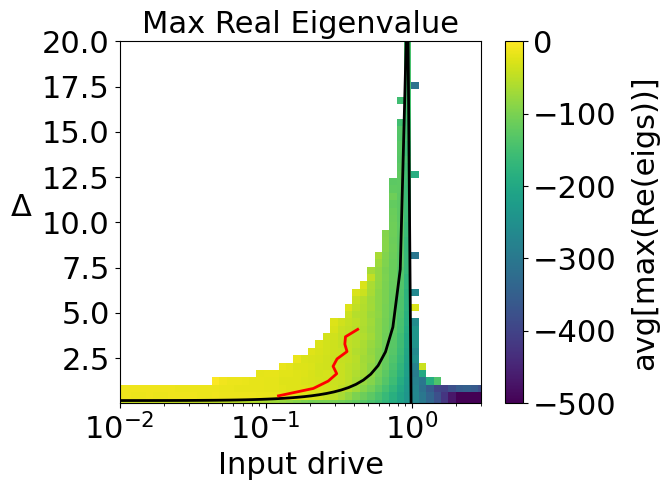

In [41]:
# Compute the maximum real part for each trial (max over eigenvalue index)
max_real_each_trial = torch.max(eigvals.real, dim=3)[0]  # shape: (num_delta, num_input, num_trials)

# Average over trials to get a 2D phase diagram (if desired)
max_real_avg = torch.nanmean(max_real_each_trial, dim=2)      # shape: (num_delta, num_input)
# calcluate the standard deviation
max_real_std = utils.nanstd(max_real_each_trial, dim=2)

# Convert to NumPy for plotting
max_real_avg_np = max_real_avg.numpy()
max_real_std_np = max_real_std.numpy()

# Determine vmin and vmax ignoring NaN values
vmin = np.nanmin(max_real_avg_np)
vmax = np.nanmax(max_real_avg_np)

# Plot the phase diagram for max(real(eigenvalues)) using a sequential colormap ("viridis")
plt.figure(figsize=(7.5, 5))
norm = mcolors.Normalize(vmin=vmin, vmax=0.0, clip=False)
mesh = plt.pcolormesh(input_range, delta_range, max_real_avg_np, cmap='viridis', norm=norm)
plt.plot(new_input_norm, delta_c, color='k', linewidth=2.0, label=r'$\Delta_c$')
colorbar = plt.colorbar(mesh, fraction=0.046, pad=0.04)
colorbar.ax.tick_params(labelsize=22)
colorbar.set_label('avg[max(Re(eigs))]', fontsize=22, rotation=90, labelpad=10)

# plot the intersection of the curves from fig3
# delta_vals_interp = np.array(sorted(intersection.keys()))
# input_vals_interp = np.array([intersection[key] for key in sorted(intersection.keys())])
# plt.scatter(input_vals_interp, delta_vals_interp, color='r', s=100, marker='x')

plt.plot(fitted_intersection, delta_range, color='red', linewidth=2.0)

plt.xlabel('Input drive', fontsize=22)
plt.ylabel(r'$\Delta$', fontsize=22, rotation=0, labelpad=15)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.title("Max Real Eigenvalue", fontsize=22)

ax = plt.gca()
if delta_scale == 'log-scale':
    plt.yscale('log')  # Ensure the axis is in log scale
    y_span = np.log10(delta_range[-1]) - np.log10(delta_range[0])
else:  
    y_span = delta_range[-1] - delta_range[0]

plt.xscale('log')
x_span = np.log10(input_range[-1]) - np.log10(input_range[0])
ax.set_aspect(x_span / y_span, adjustable='box')

plt.xlim([input_range[0], input_range[-1]])
plt.ylim([delta_range[0], delta_range[-1]])

file_name = f'avg_eigvals_{input_type}'
file_save_path = os.path.join(folder_loc, file_name)

plt.tight_layout()
plt.savefig(f'{file_save_path}.png', bbox_inches='tight')
plt.savefig(f'{file_save_path}.svg', format='svg', bbox_inches='tight', dpi=300)
plt.savefig(f'{file_save_path}.eps', format='eps', bbox_inches='tight', dpi=300)

plt.show()


/tmp/ipykernel_1617626/3248474196.py:5: RuntimeWarning: All-NaN slice encountered
  max_real_max = np.nanmax(max_real_each_trial.numpy(), axis=2)


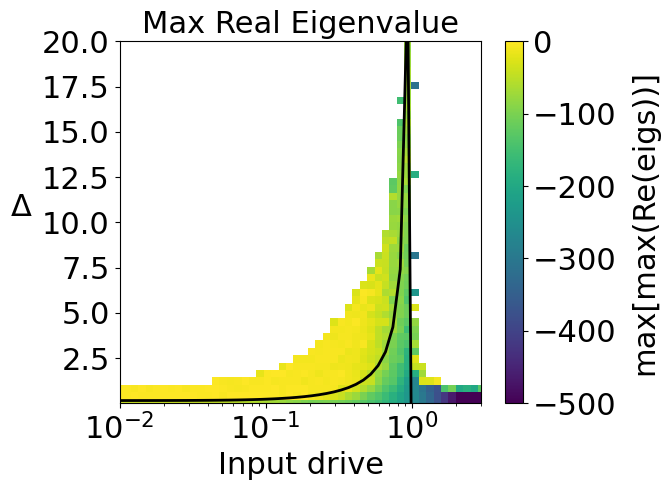

In [42]:
# Compute the maximum real part for each trial (max over eigenvalue index)
max_real_each_trial = torch.max(eigvals.real, dim=3)[0]  # shape: (num_delta, num_input, num_trials)

# find the max of the trials
max_real_max = np.nanmax(max_real_each_trial.numpy(), axis=2)

# Determine vmin and vmax ignoring NaN values
vmin = np.nanmin(max_real_max)
vmax = np.nanmax(max_real_max)

# Plot the phase diagram for max(real(eigenvalues)) using a sequential colormap ("viridis")
plt.figure(figsize=(7.5, 5))
norm = mcolors.Normalize(vmin=vmin, vmax=0.0, clip=False)
mesh = plt.pcolormesh(input_range, delta_range, max_real_max, cmap='viridis', norm=norm)
plt.plot(new_input_norm, delta_c, color='k', linewidth=2.0, label=r'$\Delta_c$')
colorbar = plt.colorbar(mesh, fraction=0.046, pad=0.04)
colorbar.ax.tick_params(labelsize=22)
colorbar.set_label('max[max(Re(eigs))]', fontsize=22, rotation=90, labelpad=10)

plt.xlabel('Input drive', fontsize=22)
plt.ylabel(r'$\Delta$', fontsize=22, rotation=0, labelpad=15)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.title("Max Real Eigenvalue", fontsize=22)

ax = plt.gca()
if delta_scale == 'log-scale':
    plt.yscale('log')  # Ensure the axis is in log scale
    y_span = np.log10(delta_range[-1]) - np.log10(delta_range[0])
else:  
    y_span = delta_range[-1] - delta_range[0]

plt.xscale('log')
x_span = np.log10(input_range[-1]) - np.log10(input_range[0])
ax.set_aspect(x_span / y_span, adjustable='box')

plt.xlim([input_range[0], input_range[-1]])
plt.ylim([delta_range[0], delta_range[-1]])

file_name = f'max_eigvals_{input_type}'
file_save_path = os.path.join(folder_loc, file_name)

plt.tight_layout()
plt.savefig(f'{file_save_path}.png', bbox_inches='tight')
plt.savefig(f'{file_save_path}.svg', format='svg', bbox_inches='tight', dpi=300)
plt.savefig(f'{file_save_path}.eps', format='eps', bbox_inches='tight', dpi=300)

plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


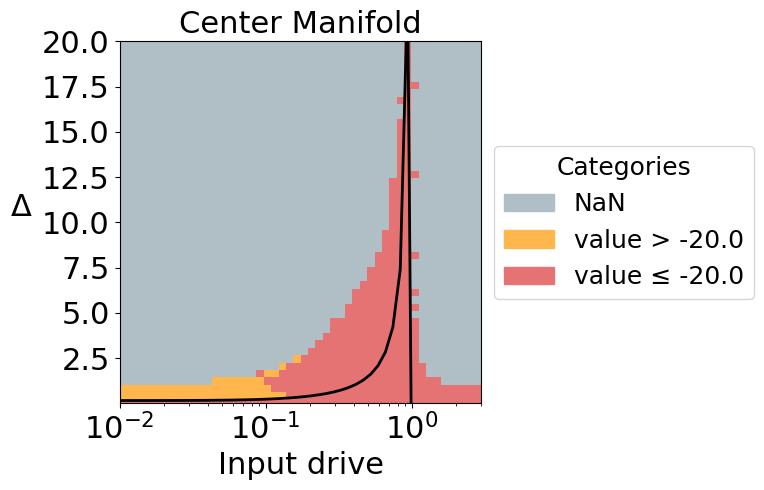

In [43]:
# Define hex codes for the three colors (change these as needed)
color_nan = "#B0BEC5"    # For NaN values
color_class1 = "#FFB74D" # For values > threshold (and < 0)
color_class2 = "#E57373" # For values ≤ threshold

# Define the threshold for center manifold (adjust as needed)
threshold = - 20.0

qty_to_check = max_real_avg_np
# qty_to_check = max_real_max
# qty_to_check = max_real_avg_np + max_real_std_np

# Create a classification array with the same shape as qty_to_check
# We assign:
#   0 for NaN values,
#   1 for values in (threshold, 0),
#   2 for values less than or equal to threshold.

classification = np.zeros_like(qty_to_check, dtype=int)
# Mark NaN values
nan_mask = np.isnan(qty_to_check)
classification[nan_mask] = 0  
# For non-NaN values, assign classes:
non_nan = ~nan_mask
# Class 1: threshold < value < 0
mask1 = (qty_to_check > threshold) & non_nan
classification[mask1] = 1
# Class 2: value ≤ threshold
mask2 = (qty_to_check <= threshold) & non_nan
classification[mask2] = 2

# Create a discrete colormap using the defined colors
from matplotlib.colors import ListedColormap
colors = [color_nan, color_class1, color_class2]
discrete_cmap = ListedColormap(colors)

# Plot the new classification
plt.figure(figsize=(7.5, 5))
mesh = plt.pcolormesh(input_range, delta_range, classification, cmap=discrete_cmap, shading='auto', vmin=0, vmax=2)
plt.plot(new_input_norm, delta_c, color='k', linewidth=2.0, label=r'$\Delta_c$')
plt.xlabel('Input drive', fontsize=22)
plt.ylabel(r'$\Delta$', fontsize=22, rotation=0, labelpad=15)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.title("Center Manifold", fontsize=22)

# Create a custom legend with the legend positioned outside the figure
import matplotlib.patches as mpatches
legend_handles = [
    mpatches.Patch(color=color_nan, label='NaN'),
    mpatches.Patch(color=color_class1, label=f'value > {threshold}'),
    mpatches.Patch(color=color_class2, label=f'value ≤ {threshold}')
]
plt.legend(handles=legend_handles, fontsize=18, title="Categories", title_fontsize=18,
           loc='center left', bbox_to_anchor=(1, 0.5))

ax = plt.gca()
if delta_scale == 'log-scale':
    plt.yscale('log')  # Ensure the axis is in log scale
    y_span = np.log10(delta_range[-1]) - np.log10(delta_range[0])
else:  
    y_span = delta_range[-1] - delta_range[0]

plt.xscale('log')
x_span = np.log10(input_range[-1]) - np.log10(input_range[0])
ax.set_aspect(x_span / y_span, adjustable='box')

plt.xlim([input_range[0], input_range[-1]])
plt.ylim([delta_range[0], delta_range[-1]])

file_name = f'center_manifold_{input_type}'
file_save_path = os.path.join(folder_loc, file_name)

plt.tight_layout()
plt.savefig(f'{file_save_path}.png', bbox_inches='tight')
plt.savefig(f'{file_save_path}.svg', format='svg', bbox_inches='tight', dpi=300)
plt.savefig(f'{file_save_path}.eps', format='eps', bbox_inches='tight', dpi=300)

plt.show()


A combined phase diagram

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


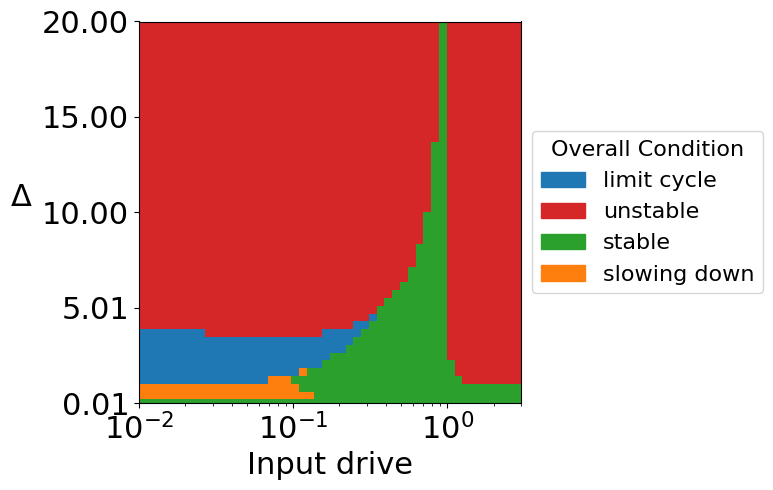

In [44]:
# -------------------------------------------------------------------------
# 1) Load your data (assuming you already have the variables in your workspace).
#    condition shape: (num_delta, num_input, num_trials)
#    eigvals   shape: (num_delta, num_input, num_trials, 2*N)
#    input_range, delta_range, etc.
# -------------------------------------------------------------------------
# For illustration, we assume you've already loaded:
#   condition, eigvals, input_range, delta_range, ...
#   from your code above.
#
# You can skip re-loading if they are already in memory.

# -------------------------------------------------------------------------
# 2) Define function to find the single "overall" condition via majority-vote
#    among the trials.
#    We treat condition=3 the same as 0 (both limit cycles).
# -------------------------------------------------------------------------
def majority_condition(conditions_1d):
    """
    Given a 1D array of trial conditions (length = num_trials),
    return the single integer condition by majority vote.
    Tie-break: pick the smallest condition ID among ties.

    We unify 3 -> 0 (both are 'limit cycle').
    """
    # Convert 3 -> 0 for counting
    conditions_unified = np.where(np.isin(conditions_1d, 3), 0, conditions_1d)

    unique_conds, counts = np.unique(conditions_unified, return_counts=True)

    # Find which condition has the maximum count
    max_count_index = np.argmax(counts)
    final_cond = unique_conds[max_count_index]
    return final_cond


# -------------------------------------------------------------------------
# 3) Compute (for each delta, input) the majority condition among the trials.
# -------------------------------------------------------------------------
num_delta, num_input, num_trials = condition.shape
final_condition_2d = np.zeros((num_delta, num_input), dtype=int)

for i_d in range(num_delta):
    for i_in in range(num_input):
        cond_1d = condition[i_d, i_in, :].cpu().numpy()
        c = majority_condition(cond_1d)
        final_condition_2d[i_d, i_in] = c  # 0, 1, or 2 by majority


# -------------------------------------------------------------------------
# 4) Among the "stable" final conditions (==2),
#    refine to condition=5 if the avg largest real eigenvalue among
#    *stable trials only* is > some threshold but still < 0
#    (i.e., negative but close to zero => "slowing down").
#
#    Adjust 'slowing_threshold' as desired.
# -------------------------------------------------------------------------
slowing_threshold = - 20.0  # example threshold for "slowing down"

# Get the real parts of eigenvalues: shape (num_delta, num_input, num_trials, 2*N)
eigvals_real = eigvals.real

# For each (delta, input), find the *stable trials* among the 100
# and compute the average of the largest real eigenvalue in those stable trials.
for i_d in range(num_delta):
    for i_in in range(num_input):

        if final_condition_2d[i_d, i_in] == 2:
            # Identify stable trials at this point
            cond_1d = condition[i_d, i_in, :].cpu().numpy()
            stable_mask = (cond_1d == 2)

            if not np.any(stable_mask):
                # No truly stable trials => skip
                continue

            # Extract the real eigenvalues of stable trials
            these_eigs = eigvals_real[i_d, i_in, stable_mask, :]  # shape = (num_stable, 2*N)
            # largest real part per stable trial
            max_real_stable = np.nanmax(these_eigs, axis=1)       # shape = (num_stable,)

            # average largest real part
            avg_max_real = np.nanmean(max_real_stable)

            # If it's "close to zero" but negative (>-0.02, say) => define condition=5
            if (avg_max_real > slowing_threshold) and (avg_max_real < 0.0):
                final_condition_2d[i_d, i_in] = 5


# -------------------------------------------------------------------------
# 5) Plot a single phase diagram with these final conditions:
#    0 (limit cycle), 1 (unstable), 2 (stable), 5 (slowing down).
# -------------------------------------------------------------------------
# We'll create a discrete colormap. We only have 4 final categories in use:
#   {0, 1, 2, 5}, but we'll map them to 0, 1, 2, 3 in an integer array for pcolormesh.
# Define a small mapping dictionary:
cond_map = {0: 0, 1: 1, 2: 2, 5: 3}  # map to [0..3]

# Build an integer array for pcolormesh
plot_data = np.full_like(final_condition_2d, fill_value=-1, dtype=int)
for c_old, c_new in cond_map.items():
    plot_data[final_condition_2d == c_old] = c_new

# Define a discrete set of colors (4 categories).
# Adjust or pick whatever colors you prefer:
colors_list = [
    "#1f77b4",  # index 0 => condition 0 => limit cycle (Muted Blue)
    "#d62728",  # index 1 => condition 1 => unstable (Brick Red)
    "#2ca02c",  # index 2 => condition 2 => stable (Forest Green)
    "#ff7f0e"   # index 3 => condition 5 => slowing down (Orange)
]
cmap_discrete = mcolors.ListedColormap(colors_list)

# Create a figure
plt.figure(figsize=(7.5, 5))
mesh = plt.pcolormesh(
    input_range,
    delta_range,
    plot_data,
    cmap=cmap_discrete,
    shading='auto',
    vmin=0,  # must match min of mapped data
    vmax=len(colors_list)  # or 4
)

# If you have a known theoretical line to plot (e.g. delta_c),
# you can overlay it:
# plt.plot(new_input_norm, delta_c, color='k', linewidth=2.0, label=r'$\Delta_c$')

# Keep the same aspect ratio logic you used elsewhere:
ax = plt.gca()
if delta_scale == 'log-scale':
    plt.yscale('log')  # Ensure the axis is in log scale
    y_span = np.log10(delta_range[-1]) - np.log10(delta_range[0])
else:  
    y_span = delta_range[-1] - delta_range[0]

plt.xscale('log')
x_span = np.log10(input_range[-1]) - np.log10(input_range[0])
ax.set_aspect(x_span / y_span, adjustable='box')

ax.set_yticks(np.linspace(delta_range[0], delta_range[-1], 5))

plt.xlim([input_range[0], input_range[-1]])
plt.ylim([delta_range[0], delta_range[-1]])

plt.xlabel('Input drive', fontsize=22)
plt.ylabel(r'$\Delta$', fontsize=22, rotation=0, labelpad=15)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

# Create a custom legend:
import matplotlib.patches as mpatches
legend_handles = [
    mpatches.Patch(color=colors_list[0], label="limit cycle"),    # Blue
    mpatches.Patch(color=colors_list[1], label="unstable"),        # Red
    mpatches.Patch(color=colors_list[2], label="stable"),          # Green
    mpatches.Patch(color=colors_list[3], label="slowing down"),    # Purple
]
plt.legend(
    handles=legend_handles,
    fontsize=16,
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    title="Overall Condition",
    title_fontsize=16
)

plt.tight_layout()

# Save if you like:
file_name = "phase_diagram_overall_condition"
file_save_path = os.path.join(folder_loc, file_name)

plt.savefig(f'{file_save_path}.png', bbox_inches='tight')
plt.savefig(f'{file_save_path}.svg', format='svg', bbox_inches='tight', dpi=300)
plt.savefig(f'{file_save_path}.eps', format='eps', bbox_inches='tight', dpi=300)

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


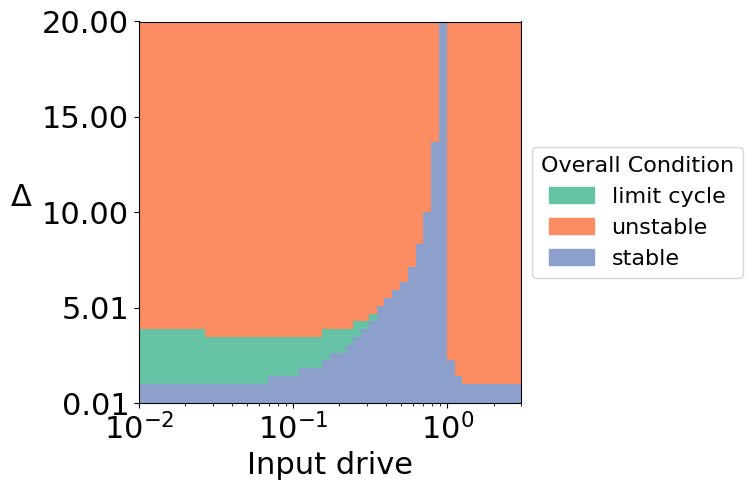

In [45]:
# Define the mapping dictionary: combine condition 2 and 5 into a single category.
cond_map = {0: 0, 1: 1, 2: 2, 5: 2}  # Both stable and slowing down are now 2

# Build an integer array for pcolormesh
plot_data = np.full_like(final_condition_2d, fill_value=-1, dtype=int)
for c_old, c_new in cond_map.items():
    plot_data[final_condition_2d == c_old] = c_new

# Example ColorBrewer "Set2" palette for 3 categories:
#   limit cycle => #66c2a5
#   unstable    => #fc8d62
#   stable      => #8da0cb
colors_list = [
    "#66c2a5",  # index 0 => condition 0 => limit cycle
    "#fc8d62",  # index 1 => condition 1 => unstable
    "#8da0cb"   # index 2 => condition 2 => stable
]
cmap_discrete = mcolors.ListedColormap(colors_list)
# delta_range = 2 * delta_range + 1
plt.figure(figsize=(7.5, 5))
mesh = plt.pcolormesh(
    input_range,
    delta_range,
    plot_data,
    cmap=cmap_discrete,
    shading='auto',
    vmin=0,
    vmax=len(colors_list)
)

# (Your existing code for aspect ratio, axes limits, ticks, etc.)
ax = plt.gca()
if delta_scale == 'log-scale':
    plt.yscale('log')  # Ensure the axis is in log scale
    y_span = np.log10(delta_range[-1]) - np.log10(delta_range[0])
else:  
    y_span = delta_range[-1] - delta_range[0]

plt.xscale('log')
x_span = np.log10(input_range[-1]) - np.log10(input_range[0])
ax.set_aspect(x_span / y_span, adjustable='box')

ax.set_yticks(np.linspace(delta_range[0], delta_range[-1], 5))
plt.xlim([input_range[0], input_range[-1]])
plt.ylim([delta_range[0], delta_range[-1]])
plt.xlabel('Input drive', fontsize=22)
plt.ylabel(r'$\Delta$', fontsize=22, rotation=0, labelpad=15)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

# Create a custom legend with a single entry for "stable" (which includes slowing down).
import matplotlib.patches as mpatches
legend_handles = [
    mpatches.Patch(color=colors_list[0], label="limit cycle"),
    mpatches.Patch(color=colors_list[1], label="unstable"),
    mpatches.Patch(color=colors_list[2], label="stable")
]

plt.legend(
    handles=legend_handles,
    fontsize=16,
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    title="Overall Condition",
    title_fontsize=16
)

plt.tight_layout()

# Save if you like:
file_name = "phase_diagram_overall_condition"
file_save_path = os.path.join(folder_loc, file_name)

plt.savefig(f'{file_save_path}.png', bbox_inches='tight')
plt.savefig(f'{file_save_path}.svg', format='svg', bbox_inches='tight', dpi=300)
plt.savefig(f'{file_save_path}.eps', format='eps', bbox_inches='tight', dpi=300)

plt.show()


delta: 2.0497959183673466, input: 0.01


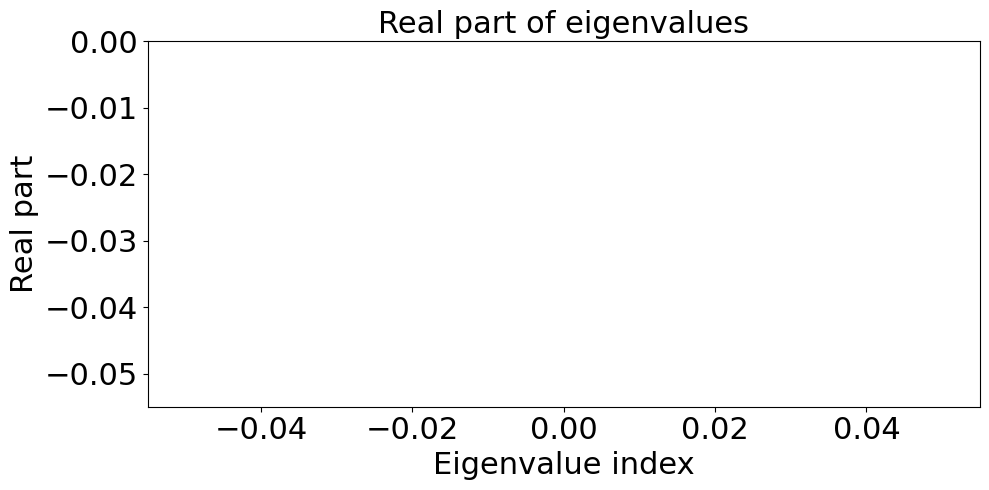

In [46]:
# finding the separation of scales in the center manifold and stable regions
trial_idx = 0
delta_idx = 5
input_idx = 0
sample_eigval = eigvals[delta_idx, input_idx, trial_idx, :]
sample_eigval_real = sample_eigval.real
# order them in descending order
sample_eigval_real = np.sort(sample_eigval_real)[::-1]

print(f'delta: {delta_range[delta_idx]}, input: {input_range[input_idx]}')

# plot the real part of eigenvalues
plt.figure(figsize=(10, 5))
plt.plot(sample_eigval_real, 'o')
plt.xlabel('Eigenvalue index', fontsize=22)
plt.ylabel('Real part', fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.title('Real part of eigenvalues', fontsize=22)
# Let matplotlib autoscale the y-axis first
plt.autoscale(axis='y')

# Get the current lower limit
current_bottom, _ = plt.ylim()

# Set only the upper limit to 0, while retaining the autoscaled lower limit
plt.ylim(current_bottom, 0)

plt.tight_layout()
plt.show()

delta: 4.0895918367346935, input: 0.032028378333286034


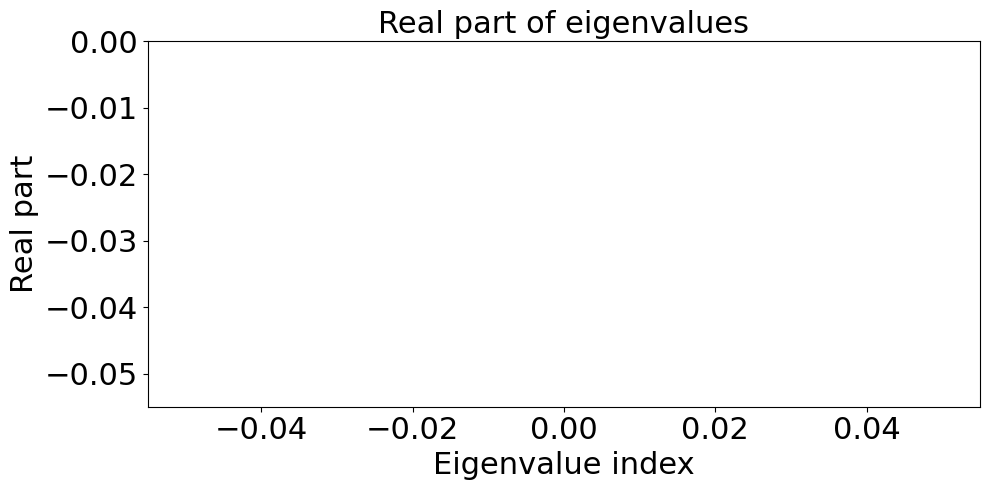

In [47]:
# finding the separation of scales in the center manifold and stable regions
delta_idx = 10
input_idx = 10
trial_idx = 0
sample_eigval = eigvals[delta_idx, input_idx, trial_idx, :]
sample_eigval_real = sample_eigval.real
sample_eigval_real = np.sort(sample_eigval_real)[::-1]

print(f'delta: {delta_range[delta_idx]}, input: {input_range[input_idx]}')

# plot the real part of eigenvalues
plt.figure(figsize=(10, 5))
plt.plot(sample_eigval_real, 'o')
plt.xlabel('Eigenvalue index', fontsize=22)
plt.ylabel('Real part', fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.title('Real part of eigenvalues', fontsize=22)
plt.tight_layout()

# Let matplotlib autoscale the y-axis first
plt.autoscale(axis='y')

# Get the current lower limit
current_bottom, _ = plt.ylim()

# Set only the upper limit to 0, while retaining the autoscaled lower limit
plt.ylim(current_bottom, 0)
plt.show()

### Frequency of oscillations

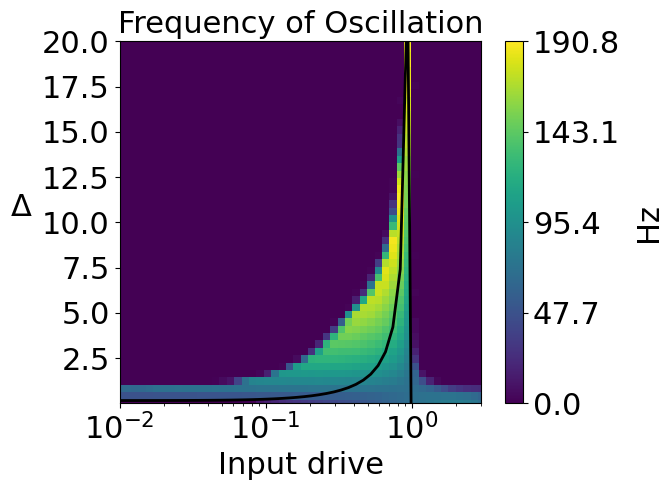

In [48]:
# Compute the maximum oscillatory frequency (absolute value of imaginary part) for each trial
# Here we take the maximum over the eigenvalue index
max_freq_each_trial = (1 / (2 * np.pi)) * torch.max(torch.abs(eigvals.imag), dim=3)[0]  # shape: (num_delta, num_input, num_trials)

# Average over trials to get a 2D phase diagram (if desired)
max_freq_avg = torch.nanmean(max_freq_each_trial, dim=2)      # shape: (num_delta, num_input)
# Calculate the standard deviation
max_freq_std = utils.nanstd(max_freq_each_trial, dim=2)

# Convert to NumPy for plotting
max_freq_avg_np = max_freq_avg.numpy()
max_freq_std_np = max_freq_std.numpy()

# Determine vmin and vmax ignoring NaN values
vmin = np.nanmin(max_freq_avg_np)
vmax = np.nanmax(max_freq_avg_np)

num_ticks = 5  # You can change this to your preferred number of ticks
ticks = np.linspace(vmin, vmax, num_ticks)

# Plot the phase diagram for frequency using a sequential colormap ("viridis")
plt.figure(figsize=(7.5, 5))
norm = mcolors.Normalize(vmin=vmin, vmax=vmax, clip=False)
mesh = plt.pcolormesh(input_range, delta_range, max_freq_avg_np, cmap='viridis', norm=norm)
plt.plot(new_input_norm, delta_c, color='k', linewidth=2.0, label=r'$\Delta_c$')


colorbar = plt.colorbar(mesh, fraction=0.046, pad=0.04, ticks=ticks)
colorbar.ax.tick_params(labelsize=22)
colorbar.set_label('Hz', fontsize=22, rotation=90, labelpad=10)

plt.xlabel('Input drive', fontsize=22)
plt.ylabel(r'$\Delta$', fontsize=22, rotation=0, labelpad=15)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.title("Frequency of Oscillation", fontsize=22)

# Create a colorbar and set a desired number of ticks (e.g., 10 ticks)

ax = plt.gca()
if delta_scale == 'log-scale':
    plt.yscale('log')  # Ensure the axis is in log scale
    y_span = np.log10(delta_range[-1]) - np.log10(delta_range[0])
else:  
    y_span = delta_range[-1] - delta_range[0]

plt.xscale('log')
x_span = np.log10(input_range[-1]) - np.log10(input_range[0])
ax.set_aspect(x_span / y_span, adjustable='box')

plt.xlim([input_range[0], input_range[-1]])
plt.ylim([delta_range[0], delta_range[-1]])


file_name = f'freq_oscillation_{input_type}'
file_save_path = os.path.join(folder_loc, file_name)

plt.tight_layout()
plt.savefig(f'{file_save_path}.png', bbox_inches='tight')
plt.savefig(f'{file_save_path}.svg', format='svg', bbox_inches='tight', dpi=300)
plt.savefig(f'{file_save_path}.eps', format='eps', bbox_inches='tight', dpi=300)

plt.show()


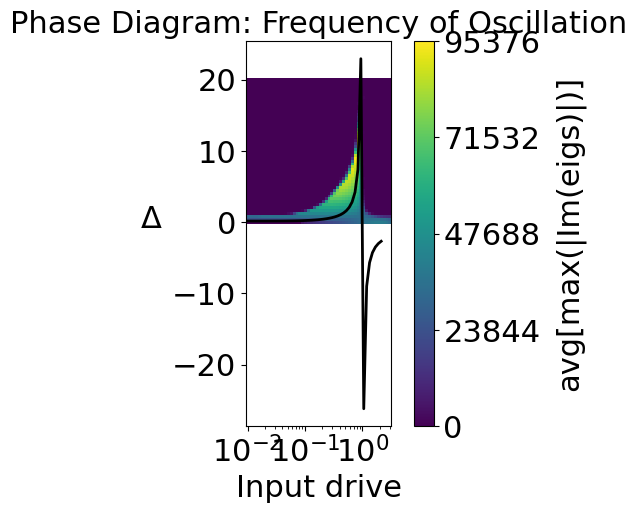

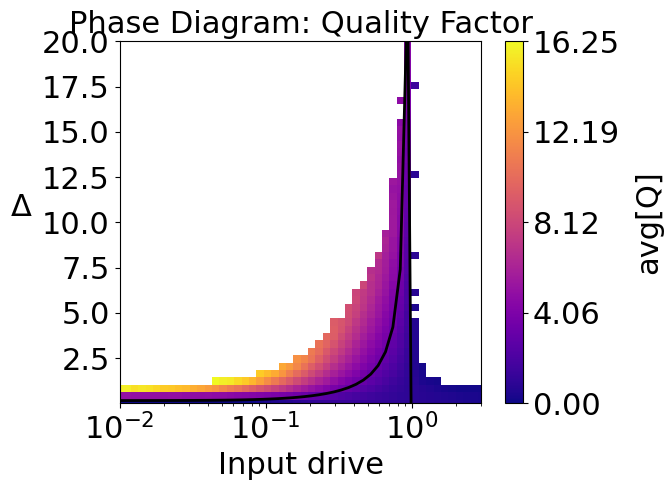

In [49]:
dt = 0.002
max_freq_each_trial = (1 / (2 * np.pi * dt)) * torch.max(torch.abs(eigvals.imag), dim=3)[0]  # shape: (num_delta, num_input, num_trials)

# --- Compute the quality factor for each trial ---
# Identify the eigenvalue index corresponding to the maximum imaginary part for each trial.
max_imag_indices = torch.argmax(torch.abs(eigvals.imag), dim=3, keepdim=True)

# Gather the corresponding real parts for that eigenvalue.
# Squeeze the singleton dimension to have shape: (num_delta, num_input, num_trials)
max_real_each_trial = torch.gather(eigvals.real, 3, max_imag_indices).squeeze(3)

# Quality factor Q = (|Im(lambda)|) / (4*pi*|Re(lambda)|)
# Note: the conversion factors cancel out when forming the ratio.
quality_factor_each_trial = torch.max(torch.abs(eigvals.imag), dim=3)[0] / (2* torch.abs(max_real_each_trial))

# --- Average over trials to get a 2D phase diagram ---
max_freq_avg = torch.nanmean(max_freq_each_trial, dim=2)      # shape: (num_delta, num_input)
max_freq_std = utils.nanstd(max_freq_each_trial, dim=2)

quality_factor_avg = torch.nanmean(quality_factor_each_trial, dim=2)
quality_factor_std = utils.nanstd(quality_factor_each_trial, dim=2)

# --- Convert to NumPy for plotting ---
max_freq_avg_np = max_freq_avg.numpy()
max_freq_std_np = max_freq_std.numpy()
quality_factor_avg_np = quality_factor_avg.numpy()
quality_factor_std_np = quality_factor_std.numpy()

# --- Determine vmin and vmax for frequency plot (ignoring NaN values) ---
vmin = np.nanmin(max_freq_avg_np)
vmax = np.nanmax(max_freq_avg_np)
num_ticks = 5  # You can change this to your preferred number of ticks
ticks = np.linspace(vmin, vmax, num_ticks)

# --- Plot the phase diagram for frequency using a sequential colormap ("viridis") ---
plt.figure(figsize=(7.5, 5))
norm = mcolors.Normalize(vmin=vmin, vmax=vmax, clip=False)
mesh = plt.pcolormesh(input_range, delta_range, max_freq_avg_np, cmap='viridis', norm=norm)
plt.plot(new_input_norm, delta_c, color='k', linewidth=2.0, label=r'$\Delta_c$')

colorbar = plt.colorbar(mesh, fraction=0.046, pad=0.04, ticks=ticks)
colorbar.ax.tick_params(labelsize=22)
colorbar.set_label('avg[max(|Im(eigs)|)]', fontsize=22, rotation=90, labelpad=10)

plt.xlabel('Input drive', fontsize=22)
plt.ylabel(r'$\Delta$', fontsize=22, rotation=0, labelpad=15)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.title("Phase Diagram: Frequency of Oscillation", fontsize=22)

ax = plt.gca()
if delta_scale == 'log-scale':
    plt.yscale('log')  # Ensure the axis is in log scale
    y_span = np.log10(delta_range[-1]) - np.log10(delta_range[0])
else:  
    y_span = delta_range[-1] - delta_range[0]

plt.xscale('log')
x_span = np.log10(input_range[-1]) - np.log10(input_range[0])
ax.set_aspect(x_span / y_span, adjustable='box')

# --- Optionally, create an additional plot for the quality factor ---
plt.figure(figsize=(7.5, 5))
q_vmin = np.nanmin(quality_factor_avg_np)
q_vmax = np.nanmax(quality_factor_avg_np)
q_ticks = np.linspace(q_vmin, q_vmax, num_ticks)
norm_q = mcolors.Normalize(vmin=q_vmin, vmax=q_vmax, clip=False)
mesh_q = plt.pcolormesh(input_range, delta_range, quality_factor_avg_np, cmap='plasma', norm=norm_q)
plt.plot(new_input_norm, delta_c, color='k', linewidth=2.0, label=r'$\Delta_c$')

colorbar_q = plt.colorbar(mesh_q, fraction=0.046, pad=0.04, ticks=q_ticks)
colorbar_q.ax.tick_params(labelsize=22)
colorbar_q.set_label('avg[Q]', fontsize=22, rotation=90, labelpad=10)

plt.xlabel('Input drive', fontsize=22)
plt.ylabel(r'$\Delta$', fontsize=22, rotation=0, labelpad=15)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.title("Phase Diagram: Quality Factor", fontsize=22)

# --- Set the aspect ratio based on input_scale (assumed defined elsewhere) ---
ax = plt.gca()
if delta_scale == 'log-scale':
    plt.yscale('log')  # Ensure the axis is in log scale
    y_span = np.log10(delta_range[-1]) - np.log10(delta_range[0])
else:  
    y_span = delta_range[-1] - delta_range[0]

plt.xscale('log')
x_span = np.log10(input_range[-1]) - np.log10(input_range[0])
ax.set_aspect(x_span / y_span, adjustable='box')

plt.xlim([input_range[0], input_range[-1]])
plt.ylim([delta_range[0], delta_range[-1]])

plt.tight_layout()
plt.show()